# Whitening transform
This notebook explores the effects of the *whitening transform*
(and its subroutine, the *Cholesky decomposition*)
on a few isolated example inputs.

### Cholesky decomposition
Decompose a matrix $M$ into two matrices $W$ of the same shape,
such that
$M = WW^{\top}$.

Note that $M$ must be
1. Symmetric
2. Positive definite
(In the example below, a covariance matrix is used.
These are always symmetric and positive definite.)

Also, $W$ is always lower triangular (i.e. entries
above the main diagonal are always 0).

It is supposedly faster than the Eigenvalue-decomposition.
PyTorch implements both only on the CPU,
so I doubt either is particularly fast to use in Neural Networks.

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import timeit

from typing import Any

from rolim.tools.stats import (sample_covar,
    randomized_multinormal_distr)
from rolim.tools.testing import assert_tensor_eq
from rolim.whitening.whitening import (
    whiten, whiten_naive, compute_whiten_error)

RNG = np.random.default_rng()

We begin with constructing a random
matrix that is symmetric and positive definite.
Covariance matrices always satisfy those requirements,
so compute the covariance matrix of a random collection of vectors:

In [2]:
shape = (3, 10)
elements = [x for x in range(shape[0]*shape[1])]
elements = RNG.permutation(elements)
sample = torch.tensor(elements, dtype=torch.float).reshape(shape)
m = sample_covar(sample)
m

tensor([[ 73.9556,  12.5778, -40.4222],
        [ 12.5778,  91.4333, -13.4000],
        [-40.4222, -13.4000,  81.3778]])

In [3]:
w = torch.linalg.cholesky(m)
print(w)
print(w @ w.T)
torch.allclose(m, w@w.T)

tensor([[ 8.5997,  0.0000,  0.0000],
        [ 1.4626,  9.4496,  0.0000],
        [-4.7004, -0.6905,  7.6686]])
tensor([[ 73.9555,  12.5778, -40.4222],
        [ 12.5778,  91.4333, -13.4000],
        [-40.4222, -13.4000,  81.3778]])


True

Note that $W$ is always lower-triangular.
So we can use torch's dedicated `torch.triangular_solve()`:

In [4]:
output = torch.triangular_solve(torch.eye(w.shape[0]), w)
print(output)
output[0] @ w

torch.return_types.triangular_solve(
solution=tensor([[0.1163, 0.0000, 0.0000],
        [0.0000, 0.1058, 0.0000],
        [0.0000, 0.0000, 0.1304]]),
cloned_coefficient=tensor([[ 8.5997,  0.0000,  0.0000],
        [ 1.4626,  9.4496,  0.0000],
        [-4.7004, -0.6905,  7.6686]]))


/tmp/ipykernel_7343/4119444925.py:1: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  output = torch.triangular_solve(torch.eye(w.shape[0]), w)


tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.1548,  1.0000,  0.0000],
        [-0.6129, -0.0900,  1.0000]])

The above does not seem very accurate.
`torch.linalg.inv()` does better:

In [5]:
torch.linalg.inv(w) @ w

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.4901e-08,  1.0000e+00,  0.0000e+00],
        [ 1.5775e-08,  1.0650e-09,  1.0000e+00]])

## Whitening transform on random 2D vectors
Experiment: sample random 2D vectors from multiple
(arbitrary) distributions, apply the whitening transform, and plot the results.

In [6]:
n1 = RNG.integers(low=10, high=100, dtype=int)
n2 = RNG.integers(low=10, high=100, dtype=int)
n3 = RNG.integers(low=10, high=100, dtype=int)

distr1 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc = torch.tensor([10, 10], dtype=torch.float), 
    covariance_matrix=torch.eye(2, dtype=torch.float)
)

distr2 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc = torch.tensor([-1, 0], dtype=torch.float), 
    covariance_matrix= torch.tensor([
        [3, 4], [4, 30]
    ], dtype=torch.float)
)

distr3 = torch.distributions.Poisson(rate=3)

In [7]:
sample1 = distr1.sample((n1,)).reshape((2, -1))
sample2 = distr2.sample((n2,)).reshape((2, -1))
sample3 = distr3.sample((2, n3))

sample = torch.concat((sample1, sample2, sample3), dim=1)
print(f"Generated random sample with shape: {sample.shape}")

whitened_sample = whiten(sample)

Generated random sample with shape: torch.Size([2, 163])


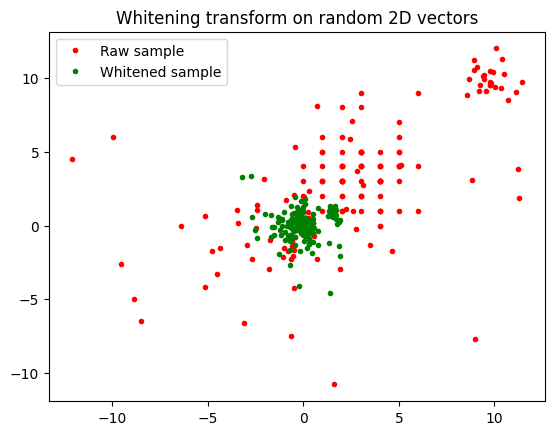

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(sample[0, :], sample[1, :], ".", color="red", label="Raw sample")
ax.plot(whitened_sample[0, :], whitened_sample[1, :], ".", color="green", label="Whitened sample")
ax.legend()
ax.set(**{"title": "Whitening transform on random 2D vectors"});

## Is there a difference between whitening implementations?
The naive method first computes the covariance $\Sigma$,
inverts it, and decomposes it using Cholesky.
The alternative method used by various authors
computes $\Sigma$, regularizes it by blending
it with a diagonal matrix (to make it *numerically*
more likely to be positive definite, I suppose),
decomposes it, and then inverts the triangular matrix.

**Fun fact:** the LWM paper implements the regularization step,
but sets the parameter to 0, basically skipping it. 🤷

**Observation:** only the parameter $\epsilon$ seems to matter?
See plot below.

TODO: compare numerically, and compare computation speed.

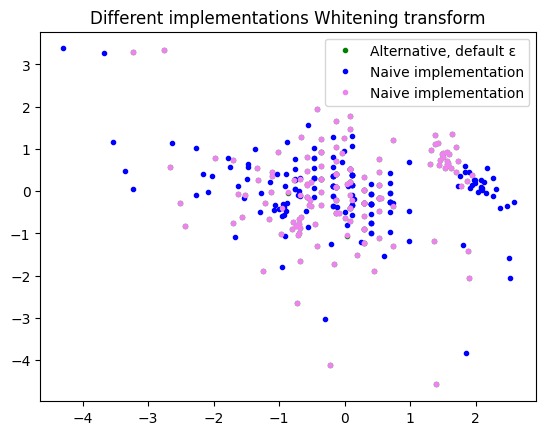

In [9]:
sample_naive_whitened = whiten_naive(sample)
sample_whitened_0_eps = whiten(sample, reg_eps=0)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(whitened_sample[0, :], whitened_sample[1, :], ".", color="green", label="Alternative, default ε")
ax.plot(sample_naive_whitened[0, :], sample_naive_whitened[1, :], ".", color="blue", label="Naive implementation")
ax.plot(sample_whitened_0_eps[0, :], sample_whitened_0_eps[1, :], ".", color="violet", label="Naive implementation")
ax.legend()
ax.set(**{"title": "Different implementations Whitening transform"});

### Random random distribution
Sample a random mean, a random covariance matrix,
and make a multinormal distribution from out
(sample the mean a standard multinormal distribution,
and the covariance as the covariance of a random standard mulinormal matrix).

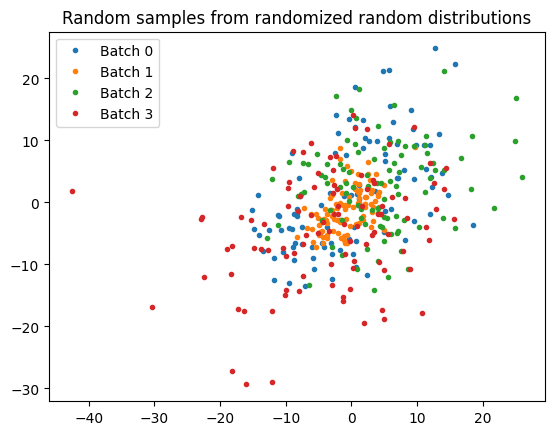

In [10]:
from numpy import dtype
from torch import Tensor


DIM = 2
SAMPLE_SIZE = 100
NUM_BATCHES = 4
PARENT_COVAR_SCALE = 100

def sample_random_random_batch(dim: int=DIM, sample_size:int=SAMPLE_SIZE) -> Tensor:
        """
        Sample a random batch of vectors from a randomized random distribution.
        See this as a 'black box' function that 
        generates magical unpredictable data.

        Arguments:
        * dim: length of output vectors.
        * sample_size: number of output vectors.

        Returns:
        * `dim×sample_size` matrix of `sample_size` column vectors of
                length `dim`.

        """
        parent_mean = torch.from_numpy((RNG.random(size=dim)-0.5)*10).to(torch.float)
        covar_scale=RNG.integers(low=1, high=100)
        distr = randomized_multinormal_distr(dim, parent_mean=parent_mean,
                covar_scale=covar_scale)
        output = distr.sample((sample_size,)).reshape(dim, sample_size)
        assert(output.shape == (dim, sample_size))
        return output
        


batches = []
for _ in range(NUM_BATCHES):
        batch = sample_random_random_batch()
        batches.append(batch)

fig, ax = plt.subplots(nrows=1, ncols=1)
i = 0
for batch in batches:
    x = batch[0,:]
    y = batch[1,:]
    ax.plot(x, y, ".", label=f"Batch {i}")
    i += 1
ax.legend()
ax.set_title("Random samples from randomized random distributions");



## Numerically comparing the different Whitening Transform implementations

In [52]:
import time
NUM_MEASUREMENTS = 100

def create_log() -> dict[str, Any]:
    output = {
        "mean_mses": [],
        "covar_mses": [],
        "runtimes": [],
        "num_failures": 0,
        "num_successes": 0
    }
    return output

def get_whiten_fun_with_fixed_eps(reg_eps: float):
    return lambda x : whiten(x, reg_eps)

setups = {
    "naive_whiten": (whiten_naive, create_log()),
    "reg_eps_0.00": (get_whiten_fun_with_fixed_eps(0), create_log()),
    "reg_eps_0.01": (get_whiten_fun_with_fixed_eps(0.01), create_log()),
    "reg_eps_0.05": (get_whiten_fun_with_fixed_eps(0.05), create_log()),
}

for i in range(NUM_MEASUREMENTS):
    batch = sample_random_random_batch()
    prev_log = None
    for (setup_name, (whiten_fun, log)) in setups.items():
        assert not (log is prev_log)
        prev_log = log
        
        try:
            start = time.time()
            whitened_batch = whiten_fun(batch)
            end = time.time()
            # runtime = timeit.timeit("whiten_fun(batch)", number=1)
        except:
            log["num_failures"] += 1
            continue
        mean_mse, covar_mse = compute_whiten_error(whitened_batch)
        log["num_successes"] += 1
        log["mean_mses"].append(mean_mse)
        log["covar_mses"].append(covar_mse)
        log["runtimes"].append(end-start)
        print(f"batch {i}: {setup_name} mse: {mean_mse:e}")
        
assert(setups["naive_whiten"][1]["mean_mses"] is not setups["reg_eps_0.00"][1]["mean_mses"])
print(setups["naive_whiten"][1]["mean_mses"][0], setups["reg_eps_0.00"][1]["mean_mses"][0])

batch 0: naive_whiten mse: 2.529532e-16
batch 0: reg_eps_0.00 mse: 5.258016e-16
batch 0: reg_eps_0.01 mse: 3.865353e-16
batch 0: reg_eps_0.05 mse: 9.009682e-16
batch 1: naive_whiten mse: 1.996625e-16
batch 1: reg_eps_0.00 mse: 4.103828e-16
batch 1: reg_eps_0.01 mse: 2.007283e-17
batch 1: reg_eps_0.05 mse: 6.079582e-17
batch 2: naive_whiten mse: 1.539320e-14
batch 2: reg_eps_0.00 mse: 1.394085e-14
batch 2: reg_eps_0.01 mse: 1.716742e-14
batch 2: reg_eps_0.05 mse: 1.324239e-14
batch 3: naive_whiten mse: 1.682565e-15
batch 3: reg_eps_0.00 mse: 1.739409e-15
batch 3: reg_eps_0.01 mse: 7.531753e-16
batch 3: reg_eps_0.05 mse: 7.986500e-16
batch 4: naive_whiten mse: 3.012701e-15
batch 4: reg_eps_0.00 mse: 3.365131e-15
batch 4: reg_eps_0.01 mse: 2.364686e-15
batch 4: reg_eps_0.05 mse: 3.558398e-15
batch 5: naive_whiten mse: 1.477929e-16
batch 5: reg_eps_0.00 mse: 1.136868e-17
batch 5: reg_eps_0.01 mse: 9.094947e-17
batch 5: reg_eps_0.05 mse: 2.273737e-16
batch 6: naive_whiten mse: 9.094946e-16


naive_whiten: 	mean:3.1602e-15, 	covar:1.9646e-01, 	runtime:1.4660e-04
reg_eps_0.00: 	mean:2.9785e-15, 	covar:1.9522e-14, 	runtime:1.6805e-04
reg_eps_0.01: 	mean:3.1532e-15, 	covar:4.7498e-05, 	runtime:1.7676e-04
reg_eps_0.05: 	mean:3.0209e-15, 	covar:1.2862e-03, 	runtime:1.5743e-04


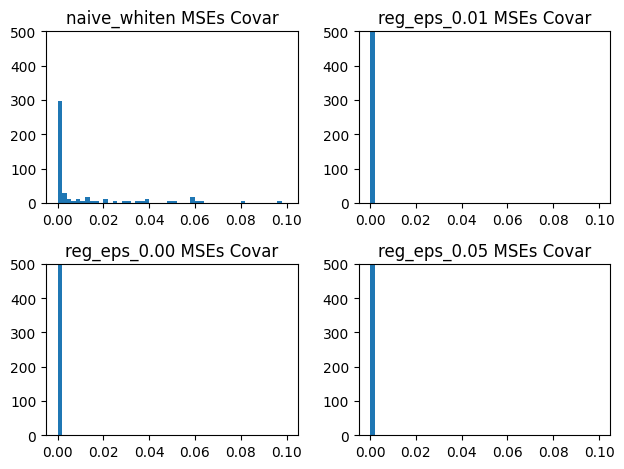

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=2)
row = 0
col = 0
for setup_name in setups.keys():
    log = setups[setup_name][1]

    ax = axes[row, col]
    ax.set_title(setup_name + " MSEs Covar")
    ax.hist(log["covar_mses"], bins=50, range=[0, 0.1], density=True)
    ax.set_ylim([0, 500])

    row += 1
    if row >= 2:
        row = 0
        col += 1

    mean_mean_mse = np.mean(log["mean_mses"])
    mean_covar_mse = np.mean(log["covar_mses"])
    mean_runtime = np.mean(log["runtimes"])
    print(f"{setup_name}: \tmean:{mean_mean_mse:.4e}, \tcovar:{mean_covar_mse:.4e}, \truntime:{mean_runtime:.4e}")

plt.tight_layout()

Outputs are typically like:

```
naive_whiten: 	mean:3.1602e-15, 	covar:1.9646e-01, 	runtime:1.4660e-04
reg_eps_0.00: 	mean:2.9785e-15, 	covar:1.9522e-14, 	runtime:1.6805e-04
reg_eps_0.01: 	mean:3.1532e-15, 	covar:4.7498e-05, 	runtime:1.7676e-04
reg_eps_0.05: 	mean:3.0209e-15, 	covar:1.2862e-03, 	runtime:1.5743e-04
```

Note that the naive whitening implementation produces orders
of magnitude larger covariance errors than the alternative implementation.
As expected, regularization introduces some error. But still less than the naive method!